# Time series clustering exercise

# Import Packages

In [509]:
import os
import pandas as pd
import numpy as np
import zipfile 
import geopandas as gpd
import pylab as pl
from scipy.cluster.vq import kmeans2,kmeans, whiten
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
import sklearn.cluster
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from IPython.display import display, clear_output
import time
% pylab inline
import scipy.cluster as scp

Populating the interactive namespace from numpy and matplotlib


# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


In [510]:
###############################################################################
ZipShape = gpd.read_file(os.getenv('PUIDATA') +\
                         '/NYC_Zipcode_Shapefile/ZIP_CODE_040114.shp')

In [511]:
###############################################################################
# Only take relevant info from Zip shape file
ZipShapedf = ZipShape[['ZIPCODE','geometry']]

# Format columns into desired format for merging later on
ZipShapedf['ZIPCODE'] = pd.to_numeric(ZipShapedf['ZIPCODE'], errors='coerce')
ZipShapedf.rename(columns={'ZIPCODE':'zip'},inplace=True)

# Review data
ZipShapedf.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


zip                                           geometry
0  11436  POLYGON ((1038098.251871482 188138.3800067157,...
1  11213  POLYGON ((1001613.712964058 186926.4395172149,...
2  11212  POLYGON ((1011174.275535807 183696.33770971, 1...
3  11225  POLYGON ((995908.3654508889 183617.6128015518,...
4  11218  POLYGON ((991997.1134308875 176307.4958601296,...

## You can use zipfile module in python to unzip the files
it should be install in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands, and miss the chance to learn something new)

In [512]:
###############################################################################
Businessdf = pd.DataFrame(columns={'zip','name','empflag','emp','qp1','ap',
                                   'est','year'})
Businessdf.head()

# For 94 to 99
for i in range(94,100,1):
    # Read in data using zip module
    fname = 'zbp' + ('{:02d}'.format(i)) + 'totals.zip'
    zf = zipfile.ZipFile(os.getenv('PUIDATA') + '/NYC_ZIPBusinessData' +\
                         '/' + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    
    # The format and naming convetnions of the data changes, so to 
    # ensure consistency these two lines of code are used
    df.columns = map(str.lower, df.columns)
    df = df[['zip','name','empflag','emp','qp1','ap','est']]
    
    # Create column for year
    df['year'] = str(19) + ('{:02d}'.format(i))
    
    # Merge onto big dataframe
    Businessdf = pd.concat([Businessdf,df])

# For 2000 to 2014
for i in range(0,15,1):
    # Read in data using zip module
    fname = 'zbp' + ('{:02d}'.format(i)) + 'totals.zip'
    zf = zipfile.ZipFile(os.getenv('PUIDATA') + '/NYC_ZIPBusinessData' +\
                         '/' + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    
    # The format and naming convetnions of the data changes, 
    # so to ensure consistence these two lines of code are used
    df.columns = map(str.lower, df.columns)
    df = df[['zip','name','empflag','emp','qp1','ap','est']]
    
    # Create column for year
    df['year'] = str(20) + ('{:02d}'.format(i))
    
    # Merge onto big dataframe
    Businessdf = pd.concat([Businessdf,df])

In [513]:
Businessdf.zip = Businessdf.zip.astype(int)
Businessdf.head()

ap     emp empflag    est         name      qp1  year   zip
0  155158.0  6198.0     NaN  439.0   Agawam, MA  33601.0  1994  1001
1  127367.0  6073.0     NaN  450.0  Amherst, MA  28924.0  1994  1002
2    1604.0    68.0     NaN   10.0  Amherst, MA    367.0  1994  1003
3    4302.0   210.0     NaN   47.0  Amherst, MA    844.0  1994  1004
4   13521.0   678.0     NaN   92.0    Barre, MA   3010.0  1994  1005

# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: we talked about the importance of "whitening" your data.
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

# Get and Prep the Data

In [514]:
# Merge df with Zip Shape file to ensure only NYC zips are included
Businessdf_ = pd.merge(Businessdf,ZipShapedf,on='zip').reset_index()

In [515]:
# Check to see differences in data sets between years
print('year','Number of Rows','Unique Zips')
for i in range(1994,2015,1):
    print(i,len(Businessdf_.zip[Businessdf_.year == str(i)]),
          len(Businessdf_.zip[Businessdf_.year == str(i)].unique()))


('year', 'Number of Rows', 'Unique Zips')
(1994, 255, 240)
(1995, 251, 237)
(1996, 252, 238)
(1997, 252, 238)
(1998, 252, 238)
(1999, 249, 236)
(2000, 253, 239)
(2001, 253, 239)
(2002, 252, 238)
(2003, 252, 238)
(2004, 251, 237)
(2005, 254, 239)
(2006, 255, 241)
(2007, 256, 242)
(2008, 253, 240)
(2009, 253, 240)
(2010, 255, 242)
(2011, 254, 241)
(2012, 252, 239)
(2013, 252, 239)
(2014, 251, 238)


It appears that there are multiple years with null data sets for differing zips, however, once we remove duplicates these disappear. It appears to be an issue with the polygons.

In [516]:
###############################################################################
# Drop duplicate data sets - seem to be identical except for geometry
Businessdf_.drop_duplicates(['zip','year'],inplace=True)

# Pivot table to pivot zips against years
Businessdf = Businessdf_.pivot(columns='zip', index='year', values='est')


In [517]:
Businessdf.head()

zip    10001   10002   10003   10004   10005   10006   10007  10009   10010  \
year                                                                          
1994  6999.0  1784.0  3256.0  1115.0  1076.0  1061.0  1307.0  634.0  3019.0   
1995  7088.0  1819.0  3377.0  1124.0  1109.0  1002.0  1274.0  633.0  2987.0   
1996  7075.0  1919.0  3417.0  1133.0  1216.0   969.0  1254.0  673.0  3029.0   
1997  7154.0  2049.0  3535.0  1173.0  1227.0   990.0  1287.0  747.0  3112.0   
1998  7254.0  2003.0  3649.0  1176.0  1270.0  1030.0  1282.0  786.0  3152.0   

zip    10011  ...    11433  11434  11435  11436  11451  11691  11692  11693  \
year          ...                                                             
1994  3301.0  ...    226.0  760.0  586.0   51.0    2.0  401.0   66.0   95.0   
1995  3340.0  ...    240.0  768.0  598.0   50.0    2.0  394.0   67.0   90.0   
1996  3392.0  ...    241.0  777.0  596.0   53.0    2.0  406.0   71.0   88.0   
1997  3541.0  ...    252.0  817.0  599.0   51.0    3.0  399.0   73.0   83.0   
1998  3599.0  ...    269.0  800.0  634.0   51.0    3.0  387.0   69.0   79.0   

zip   11694  11697  
year                
1994  294.0   33.0  
1995  285.0   32.0  
1996  287.0   34.0  
1997  294.0   38.0  
1998  291.0   38.0  

[5 rows x 245 columns]

In [518]:
# Create a normal dataframe to normalise
NormBusinessdf = Businessdf.copy()

# Create loop that normalises row by row
for i in list(NormBusinessdf.columns):
    rowmean = NormBusinessdf[i].mean()
    rowstd = NormBusinessdf[i].std()
    NormBusinessdf[i] = (NormBusinessdf[i] - rowmean) / rowstd
    
# Review data 
NormBusinessdf.head()

zip      10001     10002     10003     10004     10005     10006     10007  \
year                                                                         
1994 -1.839191 -1.713540 -1.820497 -1.512649 -2.819347  1.576901 -0.444220   
1995 -1.193297 -1.626405 -1.434653 -1.438217 -2.263972  0.902719 -0.717132   
1996 -1.287641 -1.377447 -1.307101 -1.363786 -0.463213  0.525634 -0.882533   
1997 -0.714319 -1.053802 -0.930824 -1.032980 -0.278088  0.765597 -0.609621   
1998  0.011404 -1.168323 -0.567301 -1.008170  0.445582  1.222670 -0.650971   

zip      10009     10010     10011    ...        11433     11434     11435  \
year                                  ...                                    
1994 -1.695218 -0.589198 -2.146355    ...    -2.114934 -1.632651 -1.405005   
1995 -1.700614 -1.026701 -1.938151    ...    -1.587098 -1.514780 -1.286312   
1996 -1.484761 -0.452478 -1.660546    ...    -1.549396 -1.382175 -1.306094   
1997 -1.085433  0.682297 -0.865101    ...    -1.134668 -0.792821 -1.276421   
1998 -0.874976  1.229177 -0.555464    ...    -0.493724 -1.043297 -0.930233   

zip      11436     11451     11691     11692     11693     11694     11697  
year                                                                        
1994 -1.296083 -1.134733 -0.805023 -0.947361 -0.458450 -0.842815 -1.541458  
1995 -1.347340 -1.134733 -0.967353 -0.854828 -0.710477 -1.375564 -1.716434  
1996 -1.193568 -1.134733 -0.689073 -0.484696 -0.811288 -1.257175 -1.366482  
1997 -1.296083 -0.218218 -0.851403 -0.299630 -1.063315 -0.842815 -0.666576  
1998 -1.296083 -0.218218 -1.129683 -0.669762 -1.264937 -1.020398 -0.666576  

[5 rows x 245 columns]

In [519]:
# Check for Null Values
sum(NormBusinessdf.isnull().sum())

134

In [520]:
NormBusinessdf.shape

(21, 245)

In [521]:
# Drop all values that are Null
NormBusinessdf.dropna(axis=1,inplace=True)

In [522]:
NormBusinessdf.shape
# We lose 15 Rows of Data

(21, 230)

# Cluster the number of Establishments

### First plot the time series for each zipcode

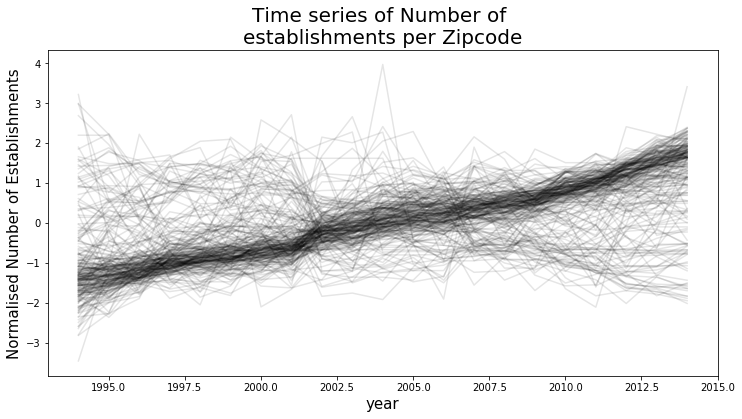

In [523]:
# Set up figure
pl.figure(figsize=(12,6))

# Plot Figure
pl.plot(NormBusinessdf,alpha=0.1,c='k');

# Format Plot
pl.title('Time series of Number of \nestablishments per Zipcode',
         fontsize=20)
pl.xlabel('year', fontsize=15)
pl.ylabel('Normalised Number of Establishments',fontsize=15)

#### Figure 1: Time series of Normalised Number of Establishments per year from 1994 to 2014
It is important to note that there is a clear trend that most of the zipcodes follow, which is indicated by the darker middle section, however there are multiple zipcodes that do not follow the same trend as can be seen by all the 'noisy' offshoot lines

# Use Elbow test to determine correct number of Clusters

In [524]:
# Function courtesy of Prof Sobolevsky
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since 
    # we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

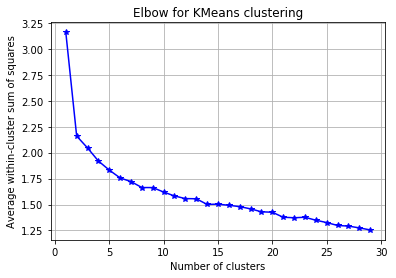

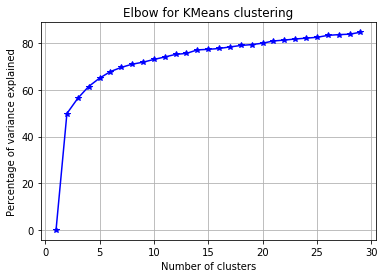

In [525]:
elbow(NormBusinessdf.T, range(1,30))

#### Figure 2: Elbow Test output of different Cluster sizes
Note how there is no clear elbow, however the best fit appears to be between 4 and 6, where the increase in cluster size starts to provide less percentage explanation in variance.

# Create Kmeans Clustering

In [526]:
# Create empty arrays
clusters = []
centers = []

# Run 3 types of clusters
for n in range(4,7,1):
    km = KMeans(random_state=300, n_clusters=n)
    res = km.fit(NormBusinessdf.T)
    clusters.append(res.labels_)
    centers.append(res.cluster_centers_)

In [527]:
# Create transposed dataframe
NormBusinessdfT = NormBusinessdf.T.copy()

# Add clusters onto Dataframe
NormBusinessdfT['4 Clusters'] = clusters[0]
NormBusinessdfT['5 Clusters'] = clusters[1]
NormBusinessdfT['6 Clusters'] = clusters[2]

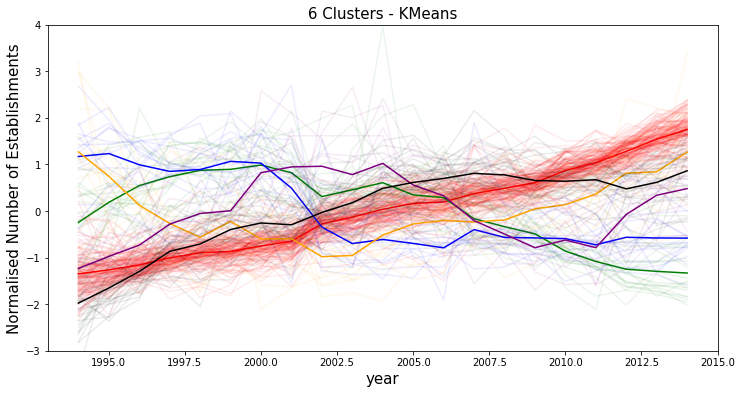

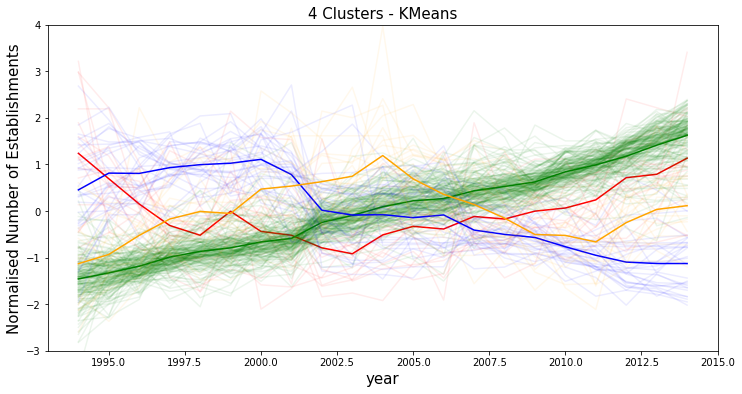

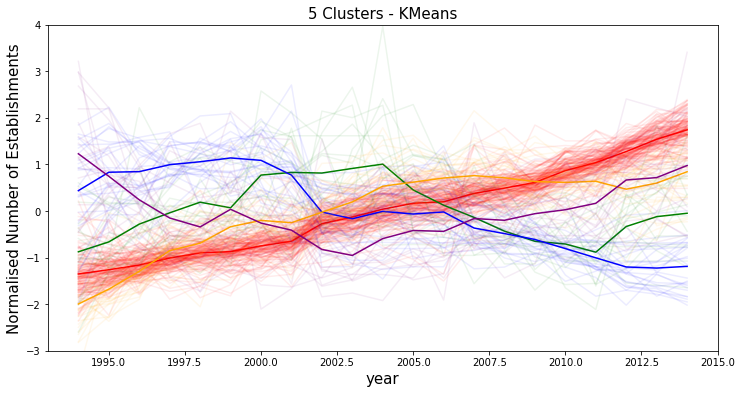

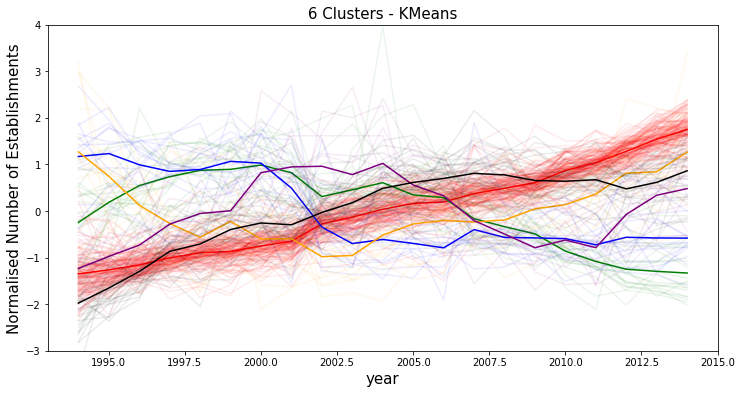

In [528]:
###############################################################################
# Define Colour Scheme
colours = ['r','g','b','orange','purple','k']

for i in range(4,7,1):
    # Set up plots
    fig, ax = pl.subplots(figsize=(12,6))
    for p in range(0,i,1):
        # Plot Time Series with colours and centroids
        pl.plot(NormBusinessdfT[NormBusinessdfT[str(i) + \
                                                ' Clusters']==p].T[:-3],
                c=colours[p],alpha=0.075)
        pl.plot(list(NormBusinessdfT.columns)[:-3],centers[i-4][p],
                c=colours[p])
        
        # Format Plots
        pl.title(str(i) + ' Clusters - KMeans',fontsize=15)
        pl.xlabel('year', fontsize=15)
        pl.ylabel('Normalised Number of Establishments',fontsize=15)
        pl.ylim(-3,4)
        
        # For Animation to display
        time.sleep(0.01) # too slow it down
        clear_output(wait=True)
        display(fig)



#### Figure 3: The Clustered time series data plotted with 3 different clusters (4,5,6)
Note how the solid line indicating the kmean value per year moves through the center of the lighter lines as expected. It is important to note that although in each case there is one clearly defined cluster, the others tend to have more variability as the noisier time series tend to to not follow as much of a pattern. 


Visually it looks like the 5 clusters may be the best in this case, as the lines seem to follow a specific trend with little deviation, whereas it becomes messy at 6 clusters and appears too coarse at 4 clusters.

# Other means of clustering - Using Dendograms

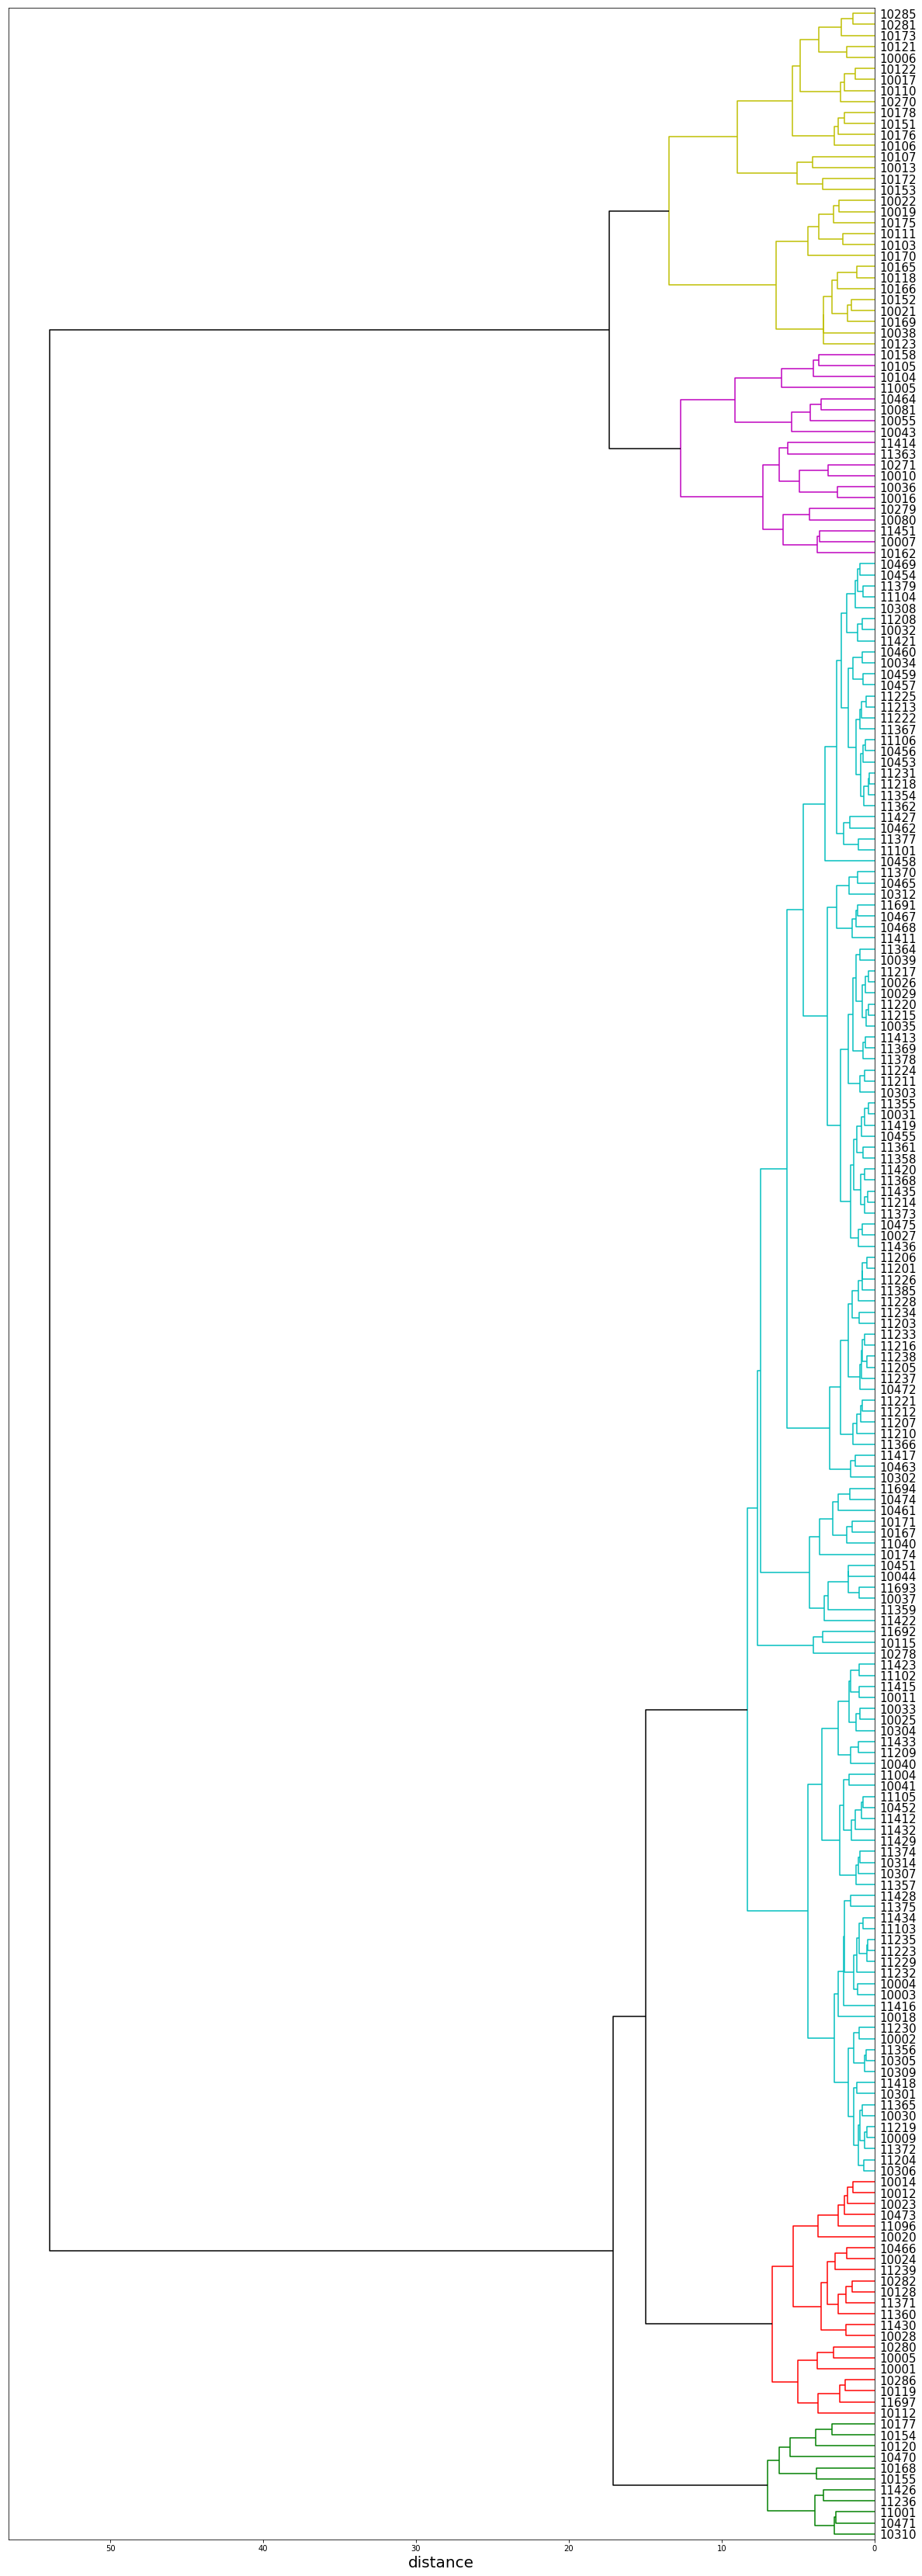

In [529]:
fig = pl.figure(figsize=(20,60))

ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(NormBusinessdf.T, method='ward'),
                               labels = list(NormBusinessdf.columns),
                               leaf_rotation=270.,# rotates the x axis labels
                               leaf_font_size=20, truncate_mode='lastp', p=250, 
                               show_contracted=True, color_threshold = 14, 
                               orientation='left', above_threshold_color='k'
                              )  # font size for the x axis labels)
#pl.xticks(rotation=90)
pl.xlabel("distance", fontsize=20)
pl.yticks(fontsize=15, rotation=0)
pl.grid('off')

#### Figure 4: Heirarchical Clustering Displayed in a Dendogram for time series of number of establishments by different zipcodes 
Note how we have set the threshold to 14 and we have 5 distinct clusters in this scenario. However, this threshold can be adjusted to show different grouoings and different levels.

This also follows the Kmeans clustering idication that there is a big cluster that most zipcodes follow (sjown as the teal group in the above figure).

# Other Clustering Methods -  Agglomerative

In [530]:
# Create empty arrays
clustersagc = []

# Run 3 types of clusters
for n in range(4,7,1):
    agc = AgglomerativeClustering(n_clusters=n,  compute_full_tree=True).fit(NormBusinessdf.T)
    clustersagc.append(agc.labels_)

In [531]:
# Add clusters onto Dataframe
NormBusinessdfT['4 Clusters AGC'] = clustersagc[0]
NormBusinessdfT['5 Clusters AGC'] = clustersagc[1]
NormBusinessdfT['6 Clusters AGC'] = clustersagc[2]

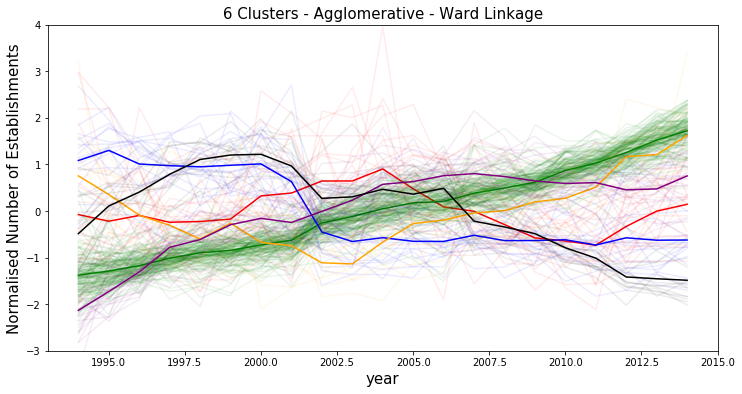

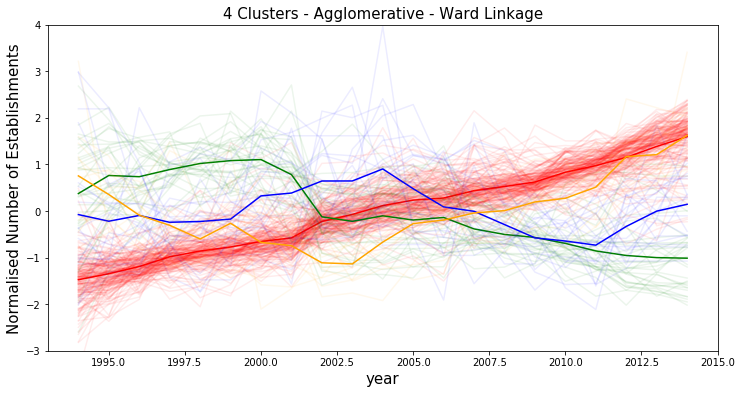

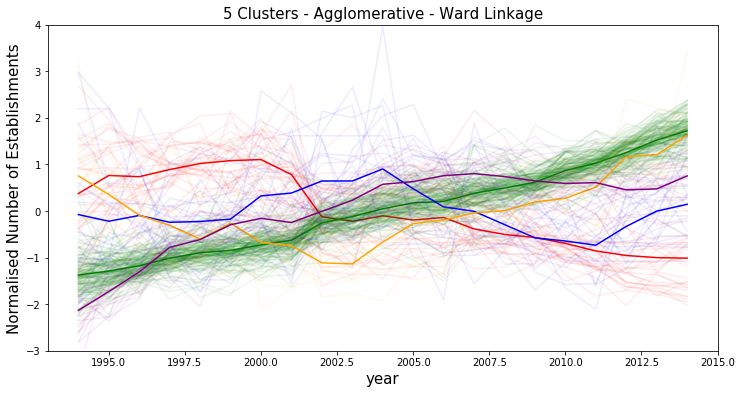

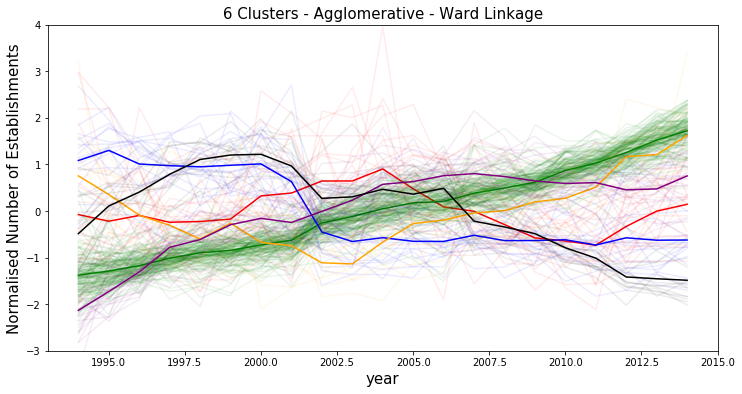

In [533]:
###############################################################################
# Define Colour Scheme
colours = ['r','g','b','orange','purple','k']


for i in range(4,7,1):
    # Set up plots
    fig, ax = pl.subplots(figsize=(12,6))
    for p in range(0,i,1):
        # Plot Time Series with colours and centroids
        pl.plot(NormBusinessdfT[NormBusinessdfT[str(i) + \
                                                ' Clusters AGC']==p].T[:-6],
                c=colours[p],alpha=0.075)
        pl.plot(list(NormBusinessdfT.columns)[:-6],
                NormBusinessdfT[NormBusinessdfT[str(i) + ' Clusters AGC'\
                                               ] ==p].mean()[:-6],c=colours[p])
        
        # Format Plots
        pl.title(str(i) + ' Clusters - Agglomerative - Ward Linkage',
                 fontsize=15)
        pl.xlabel('year', fontsize=15)
        pl.ylabel('Normalised Number of Establishments',fontsize=15)
        pl.ylim(-3,4)
        
        # For Animation to display
        time.sleep(0.01) # too slow it down
        clear_output(wait=True)
        display(fig)

#### Figure 5: Agglomeratuve - Ward Linkage Clustering with 4, 5 and 6 clusters

Note how the clusters appear very similar to the Kmeans method, although slightly different in some cases. There are similar things to note with the one strong cluster and the other clusters with more noisy data.

In [548]:
# Reviww clusters to compare differences
NormBusinessdfT[['4 Clusters','4 Clusters AGC',
                 '5 Clusters', '5 Clusters AGC', 
                 '6 Clusters','6 Clusters AGC']]

year   4 Clusters  4 Clusters AGC  5 Clusters  5 Clusters AGC  6 Clusters  \
zip                                                                         
10001           1               0           3               4           5   
10002           1               0           0               1           0   
10003           1               0           0               1           0   
10004           1               0           0               1           0   
10005           1               0           3               4           5   
10006           2               1           2               0           2   
10007           3               2           1               2           4   
10009           1               0           0               1           0   
10010           3               2           1               2           4   
10011           1               0           3               1           5   
10012           1               0           3               4           5   
10013           2               1           2               0           2   
10014           1               0           3               4           5   
10016           3               2           1               2           4   
10017           2               1           2               0           2   
10018           1               0           0               1           0   
10019           2               1           2               0           1   
10020           3               0           3               4           4   
10021           2               1           2               0           1   
10022           2               1           2               0           1   
10023           1               0           3               4           5   
10024           1               0           3               4           5   
10025           1               0           0               1           0   
10026           1               0           0               1           0   
10027           1               0           0               1           0   
10028           3               0           3               4           5   
10029           1               0           0               1           0   
10030           1               0           0               1           0   
10031           1               0           0               1           0   
10032           1               0           0               1           0   
...           ...             ...         ...             ...         ...   
11385           1               0           0               1           0   
11411           1               0           0               1           0   
11412           1               0           0               1           0   
11413           1               0           0               1           0   
11414           3               2           1               2           4   
11415           1               0           3               1           5   
11416           1               0           0               1           0   
11417           1               0           0               1           0   
11418           1               0           0               1           0   
11419           1               0           0               1           0   
11420           1               0           0               1           0   
11421           1               0           0               1           0   
11422           1               0           0               1           0   
11423           1               0           0               1           0   
11426           0               3           4               3           3   
11427           1               0           0               1           0   
11428           1               0           0               1           0   
11429           1               0           0               1           0   
11430           3               0           3               4           5

The clusters are mostly identical with different numbering schemes, however there are some differences between the two tyes of clustering methods.

# Now to plot the data on maps

First we need to merge the shapefile onto the data set.

In [536]:
# Merge data with polygons and turn into Geopandas data frame
Mapdf = pd.merge(NormBusinessdfT.reset_index(),ZipShapedf,on='zip')
Mapdf = gpd.GeoDataFrame(Mapdf)

### Now plot

In [537]:
###############################################################################
# Functions to inout discrete colour bars
# Found at http://sensitivecities.com/so-youd-like-to-make-a-
# map-using-python-EN.html#.WjKrVN-nFPY
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], 
                       colors_rgba[i, ki]) for i in xrange(N + 1)]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, 
                                                     cdict, 1024)

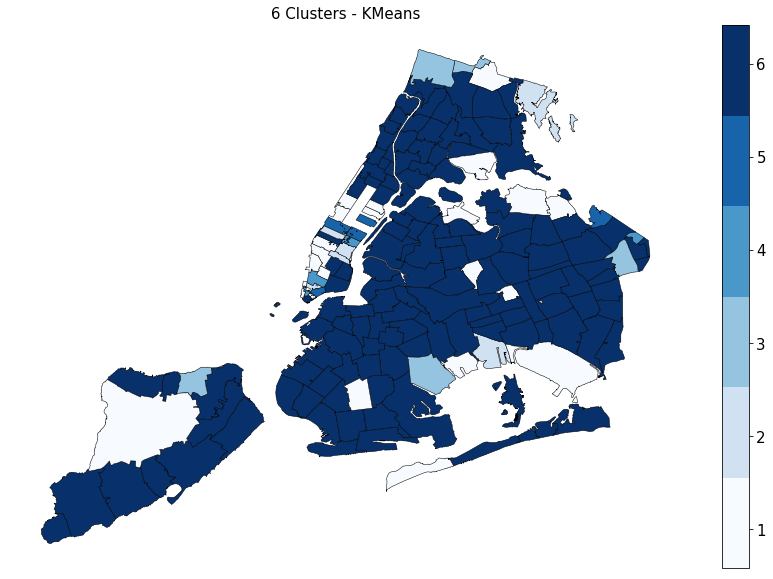

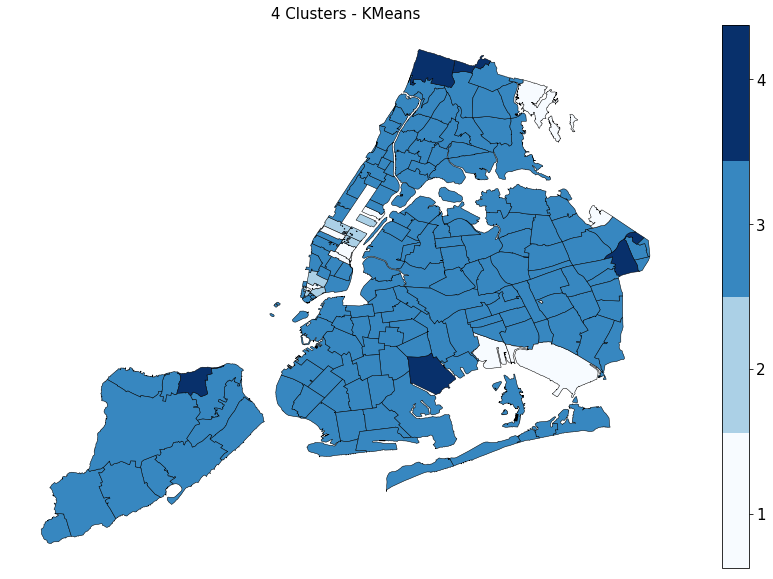

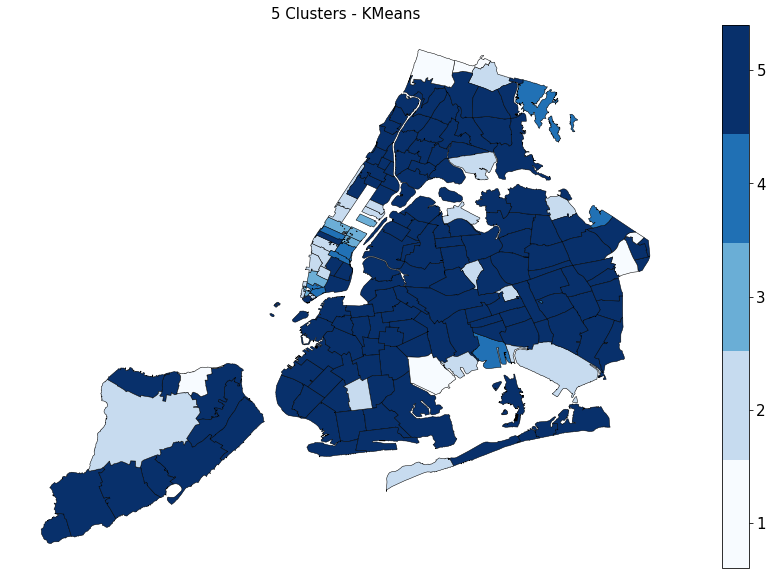

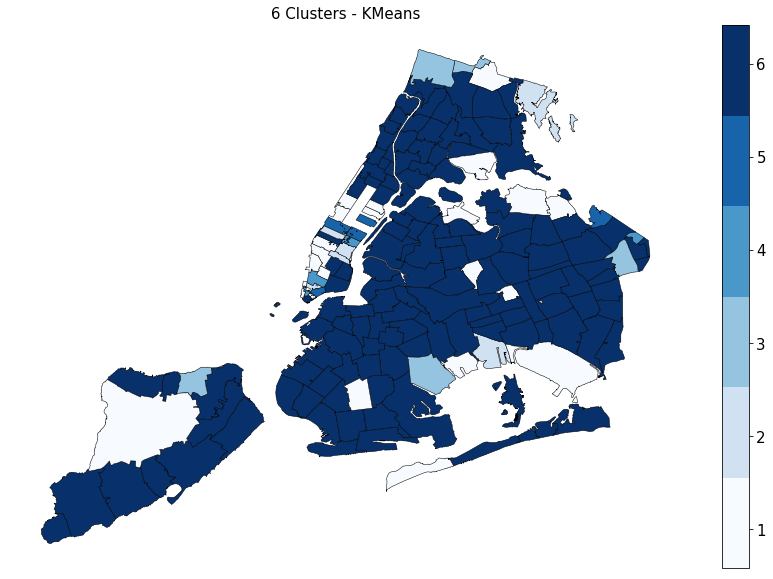

In [538]:
# Plot for each of the 3 clusters selected for Kmeans
for i in range(4,7,1):

    # Set up figures
    fig,ax = plt.subplots(figsize=(15,10))

    # Plot Data
    Mapdf.plot(column = str(i) + ' Clusters',ax=ax, 
               edgecolor='black', lw=0.5, alpha=1, 
               cmap='Blues_r',legend=False)

    # Format Plot
    ax.set_title(str(i) + ' Clusters - KMeans',fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off');
    
    # Add a colour bar
    cb = colorbar_index(ncolors=i, cmap='Blues', labels=list(np.arange(1,i+1,1)))
    cb.ax.tick_params(labelsize=15)
    
    # For Animation to display
    time.sleep(1) # too slow it down
    clear_output(wait=True)
    display(fig)


#### Figure 6: Maps showing kmean clustering of the zipcodes by number of establishments per Zipcode
For the most part, most zipcodes behave the same, however we see the biggest difference in areas in Midetown and Downtown Manhattan, which makes sense as this areas has changed substantially over the time period, and is also home to many businesses. There are a couple other areas on the outskirts of the city that also fall into different clusters. This could be attributed to the fact that it is cheaper to get property on the outskirts and could have something to do with more industrial businesses setting up shop at different time periods.

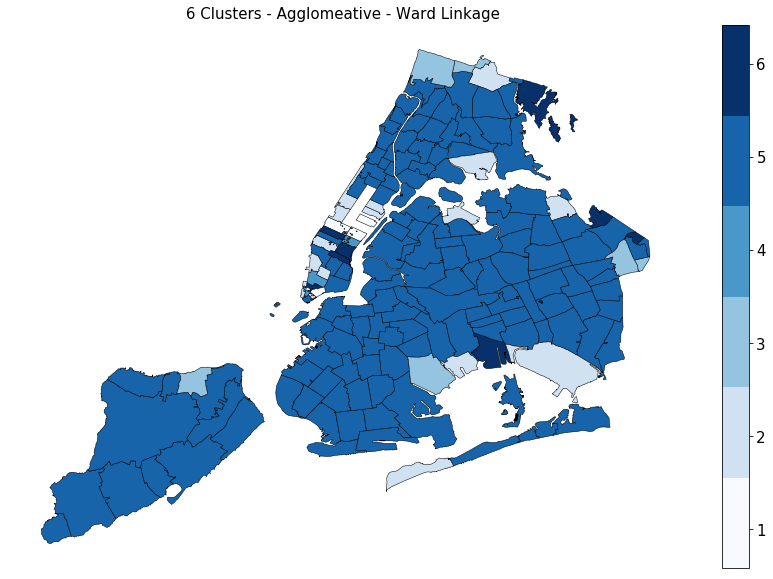

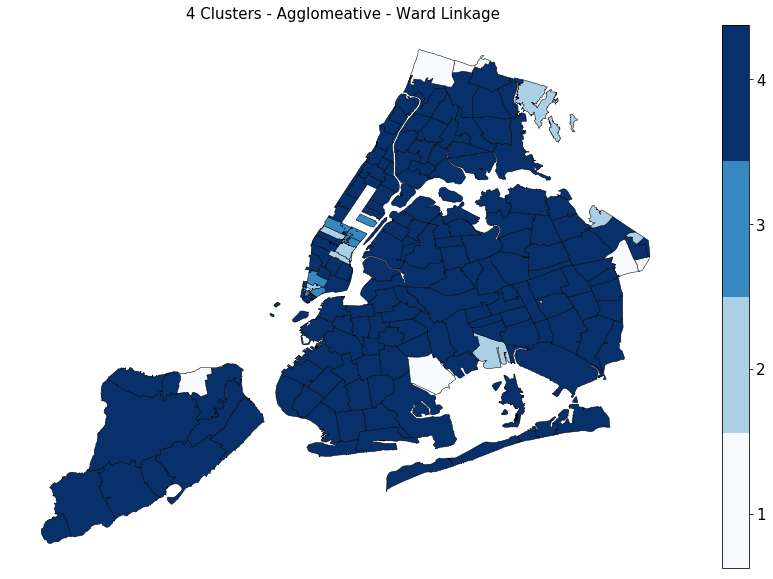

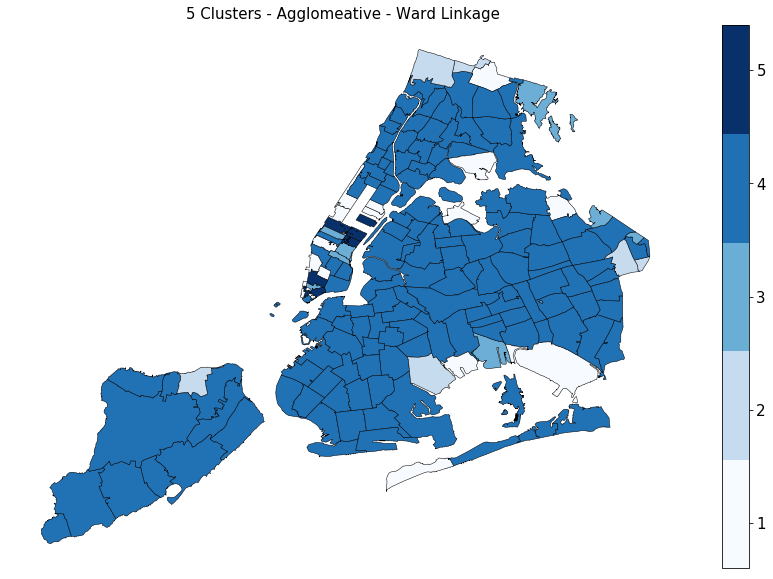

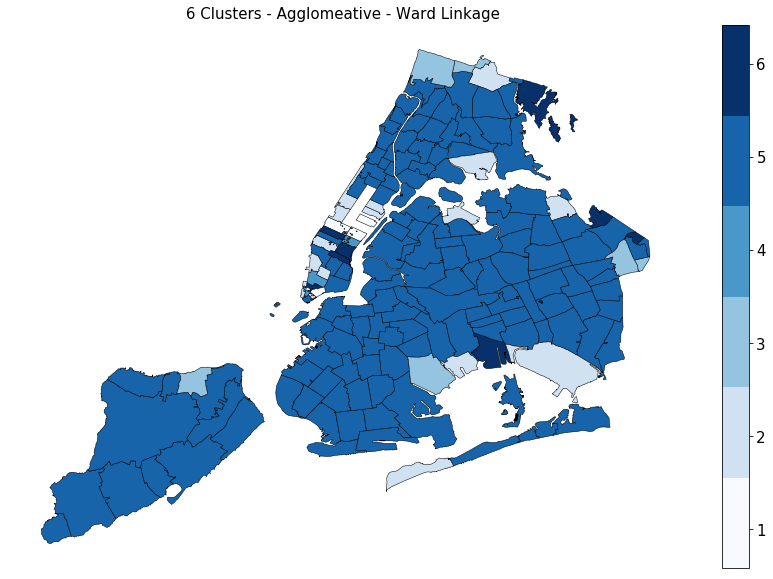

In [539]:
# Plot for each of the 3 clusters selected for Agglomorative
for i in range(4,7,1):

    # Set up figures
    fig,ax = plt.subplots(figsize=(15,10))

    # Plot Data
    Mapdf.plot(column = str(i) + ' Clusters AGC',ax=ax, 
               edgecolor='black', lw=0.5, alpha=1, 
               cmap='Blues_r',legend=False)

    # Format Plot
    ax.set_title(str(i) + ' Clusters - Agglomeative - Ward Linkage ',
                 fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off');
    
    # Add a colour bar
    cb = colorbar_index(ncolors=i, cmap='Blues', labels=list(np.arange(1,i+1,1)))
    cb.ax.tick_params(labelsize=15)
    
    # For Animation to display
    time.sleep(1) # too slow it down
    clear_output(wait=True)
    display(fig)


#### Figure 7: Maps showing agglomerative clustering of the zipcodes by number of establishments per Zipcode
For the most part, most zipcodes behave the same, however we see the biggest difference in areas in Midetown and Downtown Manhattan, which makes sense as this areas has changed substantially over the time period, and is also home to many businesses. There are a couple other areas on the outskirts of the city that also fall into different clusters. This could be attributed to the fact that it is cheaper to get property on the outskirts and could have something to do with more industrial businesses setting up shop at different time periods.

These maps are almost identical to the Kmean Clustering.

# Next Moves

Both methods of clustering showed similar results, we may want to compare the clustering with several other types of clustering methods to see if there are any major differences. For the most part, the results indicate what we would expect to see and that is Midtown and Downtown behavong dfferently to the rest of New York, most likely due to the number of businesses in these areas and because they are areas that have changed drastically in the last 20 years. It may be interesting to take the analysis slightly further and see if we can see the impacts spreading into downtown Brooklyn or potentially differences in Gentrified areas. However none of this is conclusive. 

We see similarly that the outskirts of the city behave differently. This could be attributed to the fact that these may be indistrial areas with small businesses set up to feed and support indistry as they have been pushed further from the city center due to densification and rising costs.

An important next step would be to understand which clusters are seeing businesses grow in number and which are decreasing, this could potentially be used by the city to identify areas where businesses are struggling to thrive and maybe understand what they can do support these businesses and ensure there is some form of job creation and economic stimulation in some of tehse areas and the city overall. It would be very important to try and investigate if the results can be confirmed with some groundtruth and facts about the areas that are clustered together. 